## Solución Practica

#### Objetivo: Predecir el precio del airbnb a partir del dataset proporcionado.

In [6]:
import sys  
sys.path.insert(1, "C:/Users/ASUS/Documents/GitHub/Machine-Learning-101")

In [8]:
from utils import plot_decision_boundary, poly_linear_regression, CM_BRIGHT

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

## 1. Carga de datos y división train/test

In [10]:
from sklearn.model_selection import train_test_split

airbnb_data = pd.read_csv("./airbnb-listings-extract.csv", delimiter=";")
train, test = train_test_split(airbnb_data, test_size=0.3, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardar datos por separado
train.to_csv('./airbnb-listings_train.csv', sep=';', decimal='.', index=False)
test.to_csv('./airbnb-listings_test.csv', sep=';', decimal='.', index=False)

# Cargar el dataset de train
airbnb_train_data = pd.read_csv('./airbnb-listings_train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (10346, 89)
Dimensiones del dataset de test: (4434, 89)


In [110]:
# Cargar el dataset de train
airbnb_train_data = pd.read_csv('./airbnb-listings_train.csv', sep=';', decimal='.')

## 2. Análisis exploratorio

### 2.1 Revisar la estructura de los datos:

In [112]:
# Revisar las primeras filas y su contenido
train_head = airbnb_train_data.head()
train_info = airbnb_train_data.info()
train_describe = airbnb_train_data.describe(include='all')

train_head
# , train_info, train_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10346 non-null  int64  
 1   Listing Url                     10346 non-null  object 
 2   Scrape ID                       10346 non-null  int64  
 3   Last Scraped                    10346 non-null  object 
 4   Name                            10345 non-null  object 
 5   Summary                         9922 non-null   object 
 6   Space                           7619 non-null   object 
 7   Description                     10340 non-null  object 
 8   Experiences Offered             10346 non-null  object 
 9   Neighborhood Overview           6397 non-null   object 
 10  Notes                           3960 non-null   object 
 11  Transit                         6327 non-null   object 
 12  Access                          

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,2156319,https://www.airbnb.com/rooms/2156319,20170407214119,2017-04-08,GRANT VII Plaza Mayor,NaN,Beautiful and charming apartment recently deco...,Beautiful and charming apartment recently deco...,none,NaN,...,9.0,10.0,9.0,NaN,NaN,strict,40.0,0.24,"40.4154180336,-3.70712273935","Host Has Profile Pic,Host Identity Verified,Is..."
1,3377153,https://www.airbnb.com/rooms/3377153,20170407214119,2017-04-08,Nice flat in Plaza Mayor (lift),"Flat is in the centre town, really close to Pl...",You cannot find a better location to stay in M...,"Flat is in the centre town, really close to Pl...",none,"It´s really cool, with a lot of new business (...",...,10.0,10.0,9.0,NaN,NaN,flexible,1.0,5.61,"40.411131472,-3.7072583983","Host Has Profile Pic,Host Identity Verified,Is..."
2,14800635,https://www.airbnb.com/rooms/14800635,20170407214119,2017-04-08,* ROOM double Barrio Salamanca *,"Private room for two persons has a double bed,...",It is a penthouse located in the salamanca dis...,"Private room for two persons has a double bed,...",none,The District of Salamanca is one of the 21 dis...,...,10.0,10.0,10.0,NaN,NaN,flexible,3.0,5.45,"40.4280496724,-3.6760419089","Host Has Profile Pic,Host Identity Verified,Re..."
3,11185674,https://www.airbnb.com/rooms/11185674,20170407214119,2017-04-08,cheap apartment in Madrid city cent,"Cheap apartment, next to Madrid rio, just four...",NaN,"Cheap apartment, next to Madrid rio, just four...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,0.16,"40.3964492726,-3.71409988867","Host Has Profile Pic,Is Location Exact,Require..."
4,18092171,https://www.airbnb.com/rooms/18092171,20170407214119,2017-04-08,"ACOGEDOR APARTAMENTO EN MADRID, CALLE MANZANARES","Acogedor apartamento, para parejas y/o familia.",NaN,"Acogedor apartamento, para parejas y/o familia.",none,NaN,...,NaN,NaN,NaN,NaN,NaN,strict,3.0,NaN,"40.4134467958,-3.71843838152","Host Has Profile Pic,Is Location Exact,Require..."


### [RUN] Eliminar columnas que considero que no aportan información relevante para predecir el precio.

In [114]:
def eliminar_columnas (dataset): 
    return dataset.drop(['ID', 'Space', 'Access', 'Host About', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Has Availability', 'Host Neighbourhood',
       'Description', 'Experiences Offered', 'Neighborhood Overview',  'Notes', 'Transit', 'Interaction', 'House Rules', 'Host Verifications', 'Host Response Rate', 'Review Scores Checkin',
       'Cancellation Policy', 'Jurisdiction Names', 'Geolocation', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Host ID', 'Host Response Time',
       'Host Name', 'Host Location', 'Picture Url', 'Host URL', 'License', 'Calendar Updated', 'Calendar last Scraped', 'Neighbourhood Group Cleansed', 'Neighbourhood',
       'Host Thumbnail Url', 'XL Picture Url', 'Thumbnail Url', 'Medium Url', 'Host Picture Url', 'First Review', 'Last Review', 'Features'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}') 
airbnb_train_data = eliminar_columnas(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

Cantidad de columnas antes de borrar: 89
Cantidad de columnas después de borrar: 43


In [116]:
# Revisar las primeras filas y su contenido
train_head = airbnb_train_data.head()
train_info = airbnb_train_data.info()
train_describe = airbnb_train_data.describe(include='all')

train_head
# , train_info, train_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      10344 non-null  object 
 1   Host Acceptance Rate            25 non-null     object 
 2   Host Listings Count             10344 non-null  float64
 3   Host Total Listings Count       10344 non-null  float64
 4   Street                          10346 non-null  object 
 5   Neighbourhood Cleansed          10346 non-null  object 
 6   City                            10342 non-null  object 
 7   State                           10240 non-null  object 
 8   Zipcode                         9999 non-null   object 
 9   Market                          10307 non-null  object 
 10  Smart Location                  10346 non-null  object 
 11  Country Code                    10346 non-null  object 
 12  Country                         

,Host Since,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Street,Neighbourhood Cleansed,City,State,Zipcode,Market,...,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
0,2012-01-25,NaN,40.0,40.0,"Sol, Madrid, Community of Madrid 28013, Spain",Sol,Madrid,Community of Madrid,28013,Madrid,...,9,93.0,10.0,9.0,9.0,9.0,10.0,9.0,40.0,0.24
1,2014-06-20,NaN,1.0,1.0,"La Latina, Madrid, Comunidad de Madrid 28005, ...",Embajadores,Madrid,Comunidad de Madrid,28005,Madrid,...,182,92.0,9.0,9.0,10.0,10.0,10.0,9.0,1.0,5.61
2,2016-08-05,NaN,3.0,3.0,"Madrid, Comunidad de Madrid 28006, Spain",Goya,Madrid,Comunidad de Madrid,28006,Madrid,...,38,97.0,10.0,9.0,10.0,10.0,10.0,10.0,3.0,5.45
3,2015-05-06,NaN,1.0,1.0,"Carabanchel, Madrid, Comunidad de Madrid 28019...",Comillas,Madrid,Comunidad de Madrid,28019,Madrid,...,2,80.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.16
4,2017-03-29,NaN,4.0,4.0,"Imperial, Madrid, Comunidad de Madrid 28005, S...",Imperial,Madrid,Comunidad de Madrid,28005,Madrid,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN


In [118]:
airbnb_train_data[['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']]

,Host Listings Count,Host Total Listings Count,Calculated host listings count
0,40.0,40.0,40.0
1,1.0,1.0,1.0
2,3.0,3.0,3.0
3,1.0,1.0,1.0
4,4.0,4.0,3.0
...,...,...,...
10341,1.0,1.0,1.0
10342,2.0,2.0,1.0
10343,1.0,1.0,1.0
10344,1.0,1.0,1.0


Valores faltantes por columna: 
 Host Listings Count               2
Host Total Listings Count         2
Calculated host listings count    4
dtype: int64


Correlaciones con el precio:
Host Listings Count               0.230518
Host Total Listings Count         0.230518
Calculated host listings count    0.224751
Price                             1.000000
Name: Price, dtype: float64


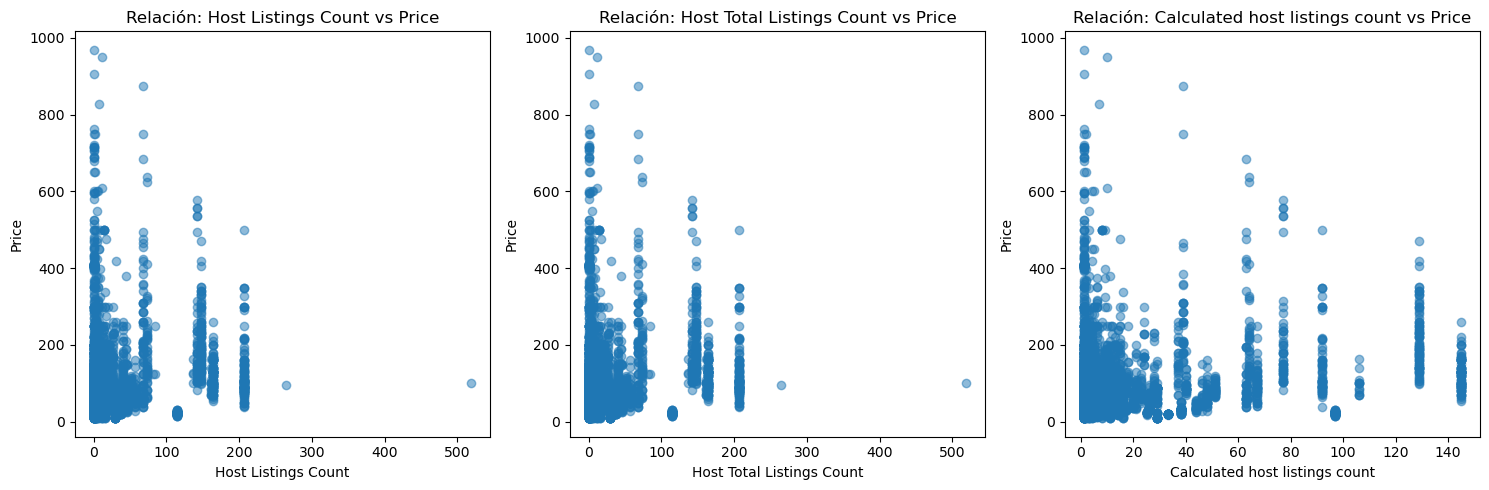

In [120]:
print(f"Valores faltantes por columna: \n {airbnb_train_data[['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']].isnull().sum()}")

print("\n")

correlations = airbnb_train_data[['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count', 'Price']].corr()
print("Correlaciones con el precio:")
print(correlations['Price'])

# Visualizar relación con el precio
plt.figure(figsize=(15, 5))
for i, column in enumerate(['Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count'], 1):
    plt.subplot(1, 3, i)
    plt.scatter(airbnb_train_data[column], airbnb_train_data['Price'], alpha=0.5)
    plt.title(f'Relación: {column} vs Price')
    plt.xlabel(column)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [122]:
def eliminar_columnas_ronda_dos (dataset): 
    return dataset.drop(['Host Total Listings Count', 'Calculated host listings count'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}') 
airbnb_train_data = eliminar_columnas_ronda_dos(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

Cantidad de columnas antes de borrar: 43
Cantidad de columnas después de borrar: 41


### Conclusiones

* **ID, Listing Url, Scrape ID, Host ID, Host URL, Picture Url, Thumbnail Url, etc.**, son identificadores únicos o enlaces que no aportan información valiosa.
* **Last Scraped, Name, Summary, Description, Experiences Offered, Neighborhood Overview, Notes, Street, etc.**, contienen texto descriptivo que probablemente no tenga un impacto significativo en este caso.
* **First Review y Last Review**: contiene fechas de la primera y última reseña que no aportan valor significativo.
* **Calendar Updated y Calendar last Scraped**: proveen información de cuándo se actualizó o descargó el calendario de disponibilidad y esto no es relevante para el calculo del precio.
* **Geolocation:** Es redudante porque ya tenemos latitud y longitud.
* **Availability 30, Availability 60, Availability 90, Availability 365**: considero que no son relevantes para calcular el precio. Estan mas enfocadas a proveer informacion sobre disponibilidad en diferentes intervalos de tiempo.
* **Host Total Listings Count**: Tienen correlaciones similares con el precio y probablemente es redundantes con Host Listings Count.

### 2.2 Detectar valores faltantes y outliers

#### Valores faltantes

In [124]:
airbnb_train_data.isnull().sum()

Host Since                         2
Host Acceptance Rate           10321
Host Listings Count                2
Street                             0
Neighbourhood Cleansed             0
City                               4
State                            106
Zipcode                          347
Market                            39
Smart Location                     0
Country Code                       0
Country                            1
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                         38
Bedrooms                          20
Beds                              34
Bed Type                           0
Amenities                        131
Square Feet                     9936
Price                             14
Weekly Price                    7833
Monthly Price                   7844
Security Deposit                5899
C

In [126]:
def mostrar_porcentaje_valores_faltantes(dataset):
    missing_percentages = dataset.isnull().mean() * 100
    print("Porcentaje de valores faltantes por columna:")
    print(missing_percentages[missing_percentages > 0].sort_values(ascending=False))

mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Porcentaje de valores faltantes por columna:
Host Acceptance Rate           99.758361
Square Feet                    96.037116
Monthly Price                  75.816741
Weekly Price                   75.710419
Security Deposit               57.017205
Cleaning Fee                   40.808042
Review Scores Value            22.994394
Review Scores Location         22.975063
Review Scores Checkin          22.955732
Review Scores Accuracy         22.907404
Review Scores Cleanliness      22.868742
Review Scores Communication    22.868742
Review Scores Rating           22.723758
Reviews per Month              21.708873
Zipcode                         3.353953
Amenities                       1.266190
State                           1.024551
Market                          0.376957
Bathrooms                       0.367292
Beds                            0.328629
Bedrooms                        0.193311
Price                           0.135318
City                            0.038662
Host Listing

#### [RUN] Se descartaran las siguientes columnas porque tienen un porcentaje muy alto de valores faltantes:
- Host Acceptance Rate (99.76%)
- Square Feet (96.04%)
- Monthly Price (75.82%)
- Weekly Price (75.71%)
- Security Deposit (57.02%)

In [128]:
def eliminar_columnas_na (dataset): 
    return dataset.drop(['Host Acceptance Rate', 'Square Feet', 'Monthly Price', 'Weekly Price', 'Security Deposit'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}')
airbnb_train_data = eliminar_columnas_na(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Cantidad de columnas antes de borrar: 41
Cantidad de columnas después de borrar: 36
Porcentaje de valores faltantes por columna:
Cleaning Fee                   40.808042
Review Scores Value            22.994394
Review Scores Location         22.975063
Review Scores Checkin          22.955732
Review Scores Accuracy         22.907404
Review Scores Communication    22.868742
Review Scores Cleanliness      22.868742
Review Scores Rating           22.723758
Reviews per Month              21.708873
Zipcode                         3.353953
Amenities                       1.266190
State                           1.024551
Market                          0.376957
Bathrooms                       0.367292
Beds                            0.328629
Bedrooms                        0.193311
Price                           0.135318
City                            0.038662
Host Listings Count             0.019331
Host Since                      0.019331
Country                         0.009666
dtype: flo

#### Imputación

In [130]:
airbnb_train_data[['Bathrooms', 'Beds', 'Bedrooms']].describe()

,Bathrooms,Beds,Bedrooms
count,10308.000000,10312.000000,10326.000000
mean,1.289726,2.053627,1.347376
std,0.668635,1.626308,0.904172
min,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,2.000000,1.000000
75%,1.000000,2.000000,2.000000
max,8.000000,16.000000,10.000000


#### Imputare los valores nulos de tipo numerico con la mediana ya que no quiero que se vean afectado por los outliers.

In [132]:
numerical_columns = ['Bathrooms', 'Beds', 'Bedrooms', 'Price', 'Cleaning Fee', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Reviews per Month']

for column in numerical_columns:
    airbnb_train_data[column] = airbnb_train_data[column].fillna(airbnb_train_data[column].median())

mostrar_porcentaje_valores_faltantes(airbnb_train_data)

Porcentaje de valores faltantes por columna:
Zipcode                3.353953
Amenities              1.266190
State                  1.024551
Market                 0.376957
City                   0.038662
Host Since             0.019331
Host Listings Count    0.019331
Country                0.009666
dtype: float64


In [134]:
airbnb_train_data.describe()

airbnb_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Host Since                   10344 non-null  object 
 1   Host Listings Count          10344 non-null  float64
 2   Street                       10346 non-null  object 
 3   Neighbourhood Cleansed       10346 non-null  object 
 4   City                         10342 non-null  object 
 5   State                        10240 non-null  object 
 6   Zipcode                      9999 non-null   object 
 7   Market                       10307 non-null  object 
 8   Smart Location               10346 non-null  object 
 9   Country Code                 10346 non-null  object 
 10  Country                      10345 non-null  object 
 11  Latitude                     10346 non-null  float64
 12  Longitude                    10346 non-null  float64
 13  Property Type   

In [136]:
airbnb_train_data.isnull().sum()

Host Since                       2
Host Listings Count              2
Street                           0
Neighbourhood Cleansed           0
City                             4
State                          106
Zipcode                        347
Market                          39
Smart Location                   0
Country Code                     0
Country                          1
Latitude                         0
Longitude                        0
Property Type                    0
Room Type                        0
Accommodates                     0
Bathrooms                        0
Bedrooms                         0
Beds                             0
Bed Type                         0
Amenities                      131
Price                            0
Cleaning Fee                     0
Guests Included                  0
Extra People                     0
Minimum Nights                   0
Maximum Nights                   0
Number of Reviews                0
Review Scores Rating

### Eliminar filas que quedaron con valores nulos

In [141]:
columns_with_nulls = [
    'Host Since', 'Host Listings Count', 'State', 'Zipcode', 'Market', 
    'City', 'Amenities', 'Country'
]

# Eliminar filas con valores nulos en las columnas especificadas
print(f'Cantidad de filas antes de borrar: {airbnb_train_data.shape[0]}')
airbnb_train_data = airbnb_train_data.dropna(subset=columns_with_nulls)
print(f'Cantidad de filas después de borrar: {airbnb_train_data.shape[0]}')

Cantidad de filas antes de borrar: 10346
Cantidad de filas después de borrar: 9732


In [143]:
airbnb_train_data.isnull().sum()

Host Since                     0
Host Listings Count            0
Street                         0
Neighbourhood Cleansed         0
City                           0
State                          0
Zipcode                        0
Market                         0
Smart Location                 0
Country Code                   0
Country                        0
Latitude                       0
Longitude                      0
Property Type                  0
Room Type                      0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Beds                           0
Bed Type                       0
Amenities                      0
Price                          0
Cleaning Fee                   0
Guests Included                0
Extra People                   0
Minimum Nights                 0
Maximum Nights                 0
Number of Reviews              0
Review Scores Rating           0
Review Scores Accuracy         0
Review Sco

#### Identificar outliers en columnas numéricas

In [145]:
numerical_columns = airbnb_train_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns

Index(['Host Listings Count', 'Latitude', 'Longitude', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month'],
      dtype='object')

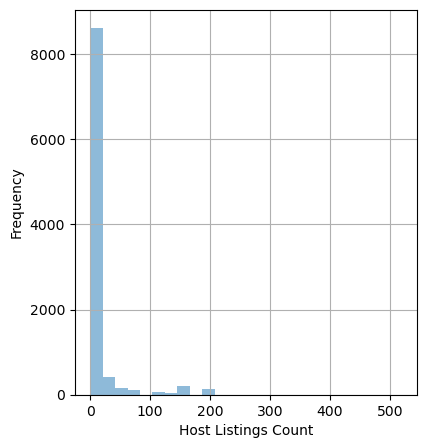

In [147]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)

for i, column in enumerate(numerical_columns, 1):
    airbnb_train_data[column].plot.hist(alpha=0.5, bins=25, grid = True)
    #plt.yscale("log")
    plt.xlabel(column)
    plt.show()
    break

#### Visualizar outliers con boxplots

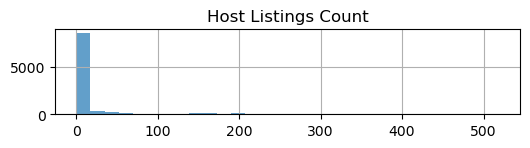

In [159]:
# Visualizar distribuciones de las columnas numéricas
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot((len(numerical_columns) // 3) + 1, 3, i)
    airbnb_train_data[column].hist(bins=30, alpha=0.7)
    plt.title(column)
    break
plt.tight_layout()
plt.show()

C:\Users\ASUS\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 1500x500 with 0 Axes>

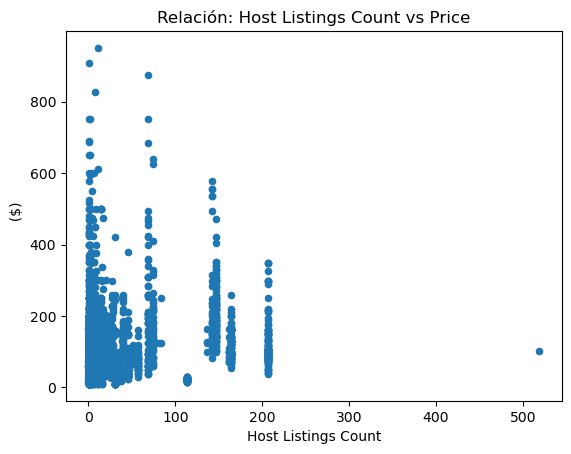

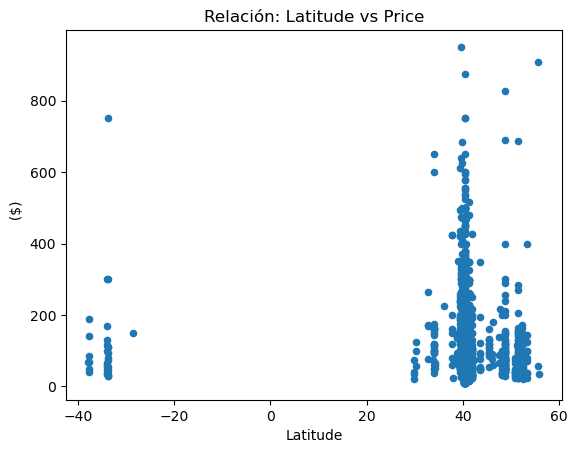

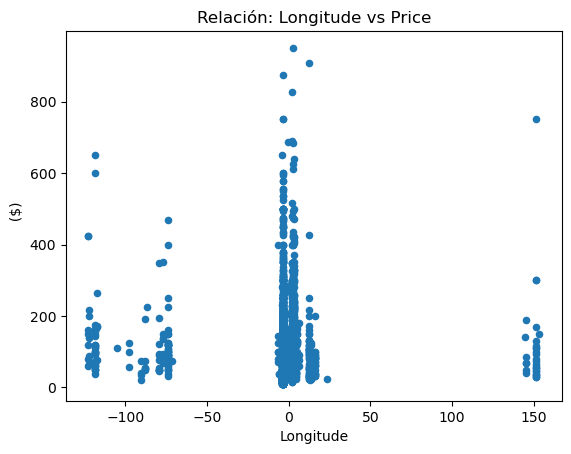

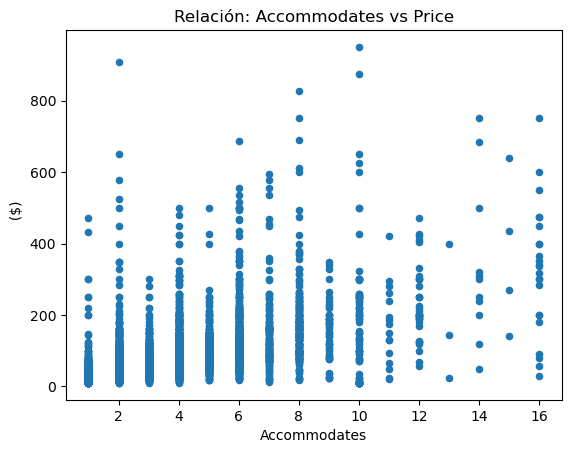

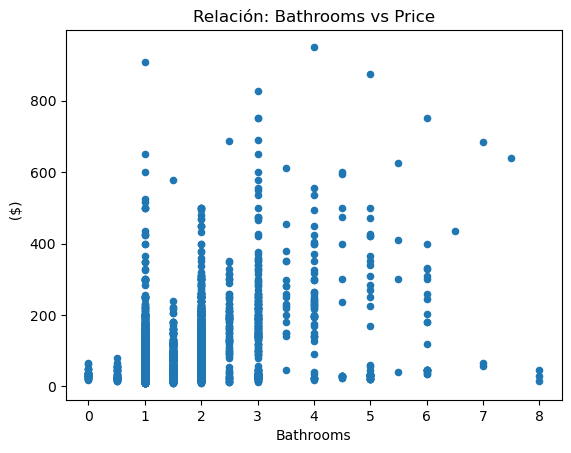

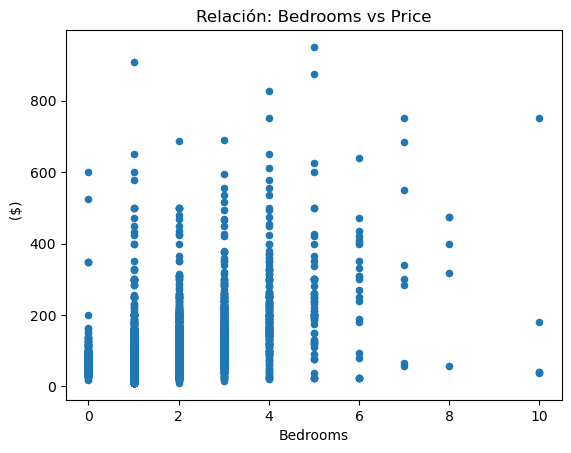

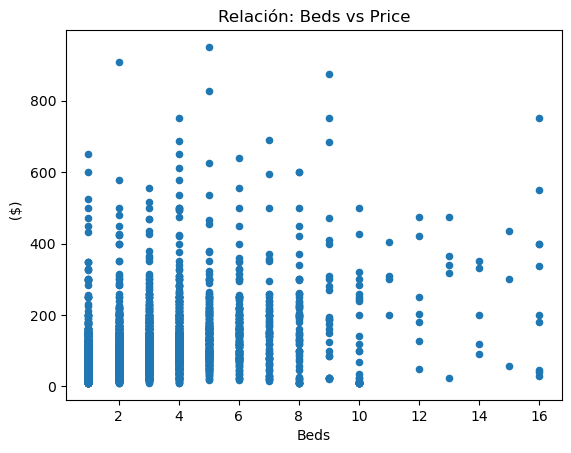

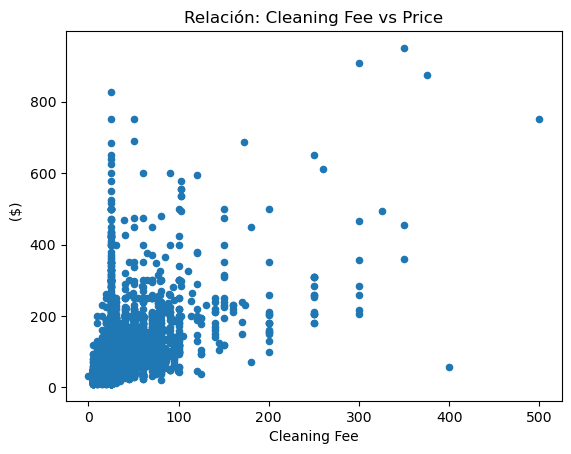

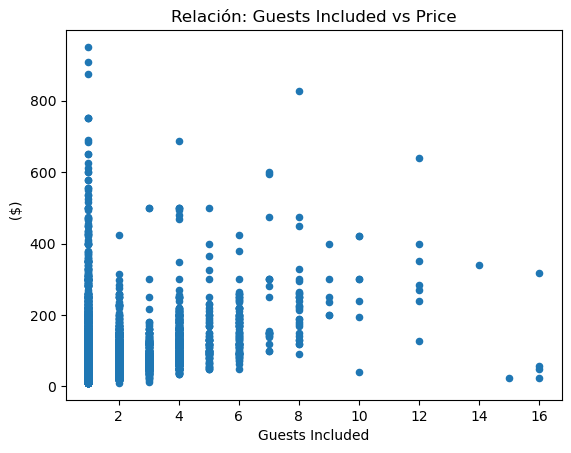

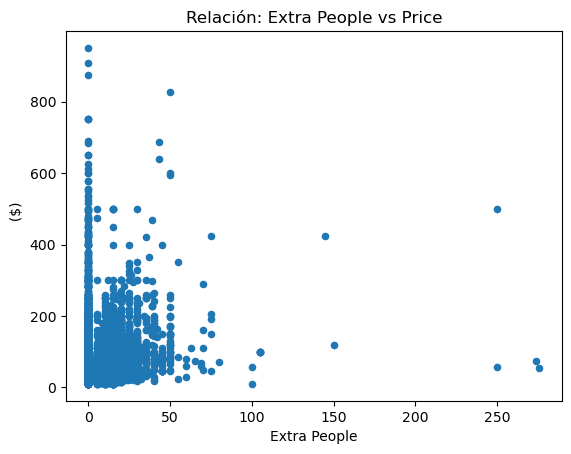

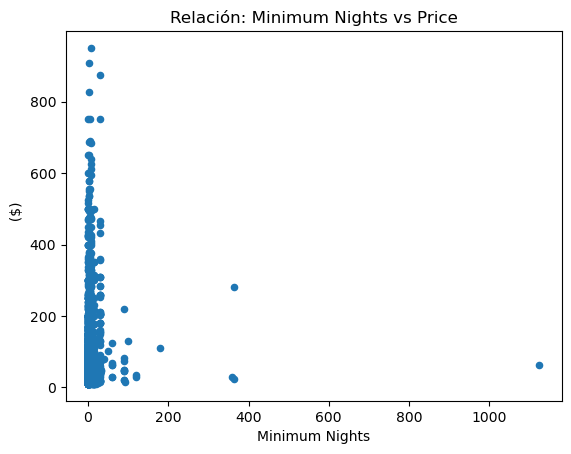

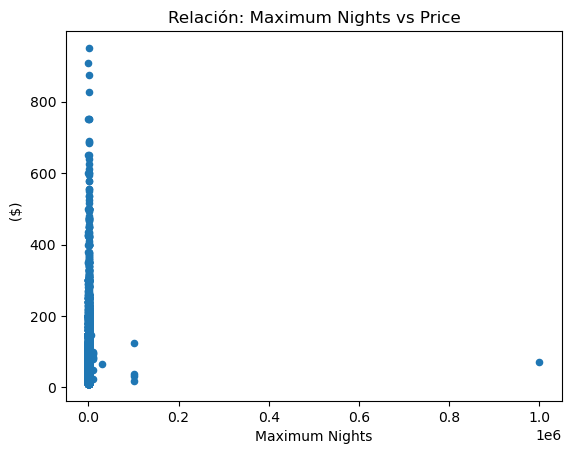

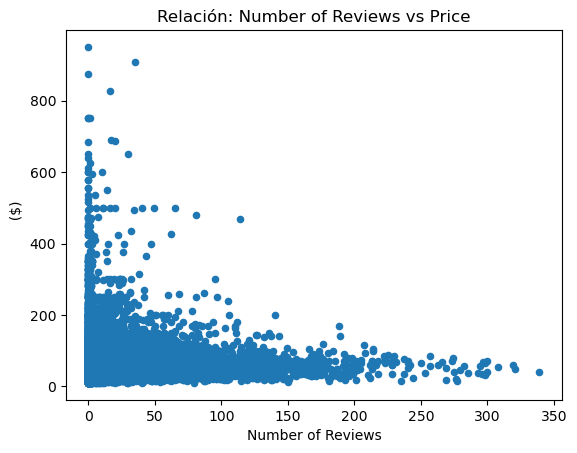

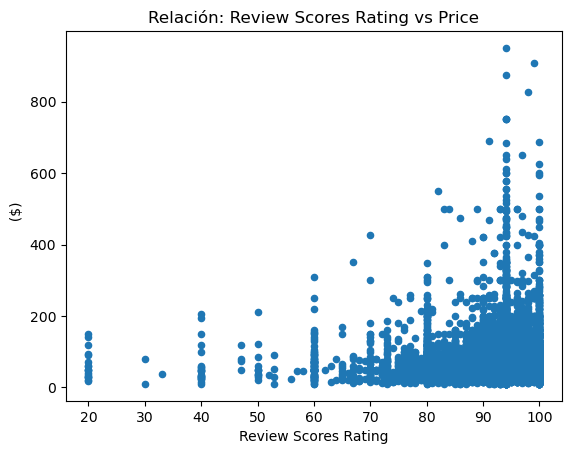

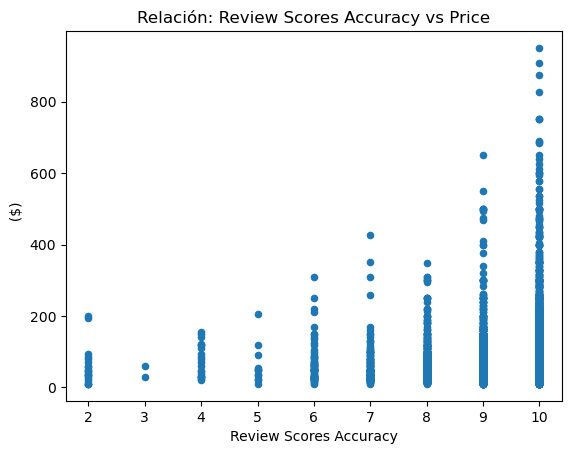

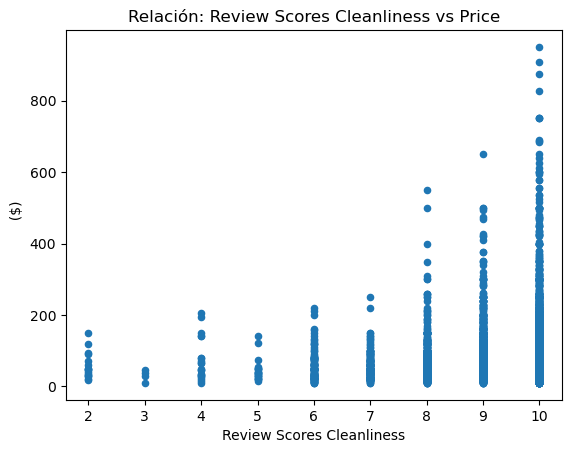

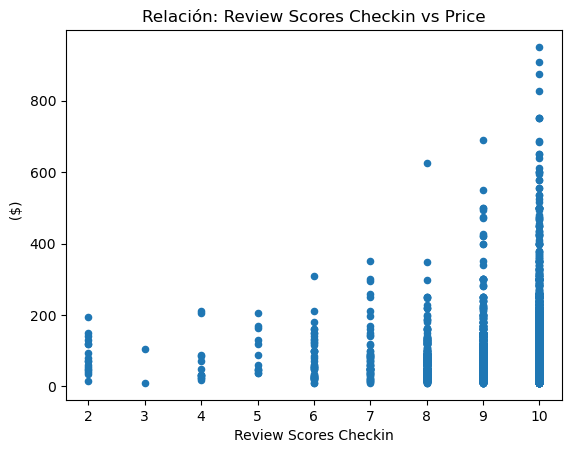

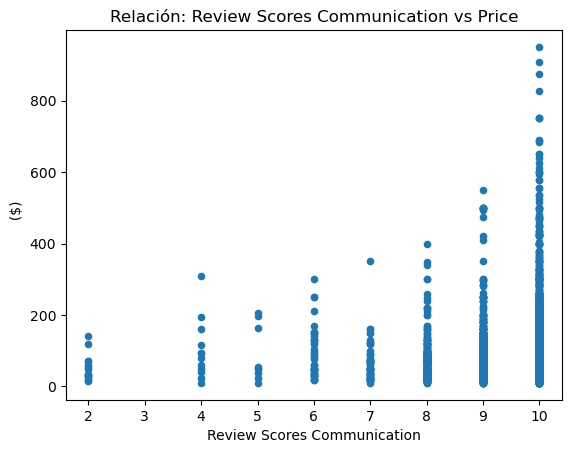

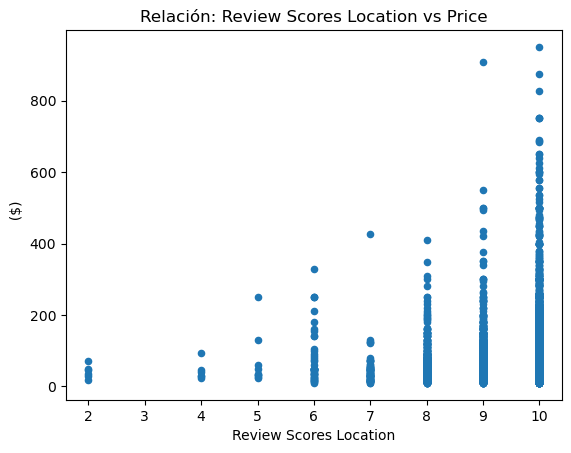

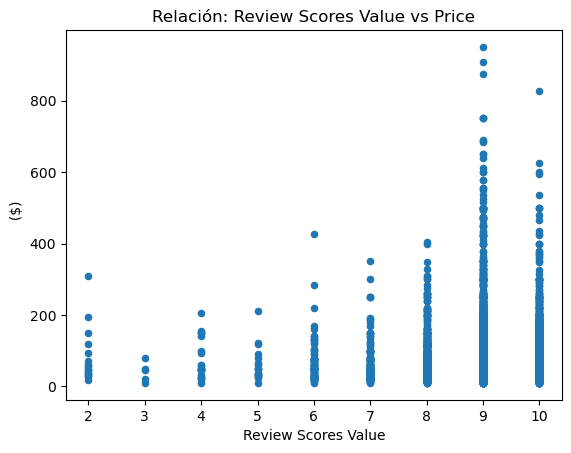

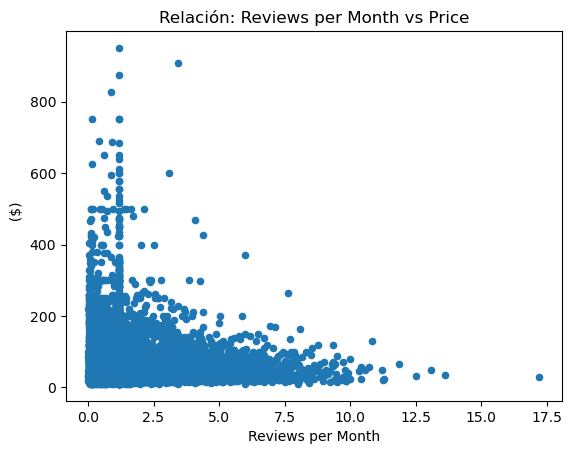

In [155]:
# Relación entre `Price` y las columnas numéricas
plt.figure(figsize=(15, 5))
for i, column in enumerate(numerical_columns, 1):
    if column != 'Price':
        airbnb_train_data.plot(kind = 'scatter',x=column,y = 'Price')
        plt.title(f"Relación: {column} vs Price")
        plt.xlabel(column)
        plt.ylabel('  ($)')
        # break
plt.show()

### Conclusiones
* Existe una relación positiva entre Accommodates y Price, alojamientos con mayor capacidad tienden a ser más caros.
    * En alojamientos con mayor capacidad (más de 8 personas) el precio tiende a ser consistentemente más alto.
* Tambien hay una relación positiva entre Bathrooms y Price, más baños generalmente estan asociados con alojamientos más caros.
    * El precio generalmente aumenta con el número de baños pero hay menos alojamientos con más de 3 baños.
    * Algunos alojamientos con 2-3 baños tienen precios muy altos, lo mas probablemente es que sea debido a factores externos.
* Los precios más altos están asociados con alojamientos que tienen puntuaciones de limpieza de 9 o 10.
* No veo relación fuerte de los campos Review Scores Communication y Review Scores Checkin con el precio.

In [165]:
def eliminar_columnas_ronda_tres (dataset): 
    return dataset.drop(['Review Scores Communication', 'Review Scores Checkin'], axis=1)

print(f'Cantidad de columnas antes de borrar: {airbnb_train_data.shape[1]}') 
airbnb_train_data = eliminar_columnas_ronda_tres(airbnb_train_data)
print(f'Cantidad de columnas después de borrar: {airbnb_train_data.shape[1]}')

Cantidad de columnas antes de borrar: 36
Cantidad de columnas después de borrar: 34
